In [1]:
import pandas as pd

df = pd.read_csv("AccidentLondonBoroughs2223.csv")
df.head()


,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,200501BS00001,525680,178240,-0.191170,51.489096,1,2,1,1,04/01/2005,...,0,1,1,2,2,0,0,1,1,E01002849
1,200501BS00002,524170,181650,-0.211708,51.520075,1,3,1,1,05/01/2005,...,0,5,4,1,1,0,0,1,1,E01002909
2,200501BS00003,524520,182240,-0.206458,51.525301,1,3,2,1,06/01/2005,...,0,0,4,1,1,0,0,1,1,E01002857
3,200501BS00004,526900,177530,-0.173862,51.482442,1,3,1,1,07/01/2005,...,0,0,1,1,1,0,0,1,1,E01002840
4,200501BS00005,528060,179040,-0.156618,51.495752,1,3,1,1,10/01/2005,...,0,0,7,1,2,0,0,1,1,E01002863


In [2]:
hav = df[df["Local_Authority_Highway"]=="E09000016"].copy()
len(hav)


4023

In [3]:
# Save as run_havering_analysis.py or paste into a Jupyter cell
import pandas as pd, numpy as np, os
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

csv_path = "/mnt/data/AccidentLondonBoroughs2223.csv"
out_dir = "/mnt/data/analysis_outputs"
os.makedirs(out_dir, exist_ok=True)

df = pd.read_csv(csv_path, low_memory=False)

# 1) filter Havering
if "Local_Authority_Highway" in df.columns:
    hav = df[df["Local_Authority_Highway"]=="E09000016"].copy()
else:
    # fallback search
    hav = df[df.apply(lambda r: r.astype(str).str.contains("Havering", case=False).any(), axis=1)]

# 2) parse datetime & extract hour/week/day
if "Time" in hav.columns:
    hav["Time_parsed"] = pd.to_datetime(hav["Time"], errors="coerce")
    hav["Hour"] = hav["Time_parsed"].dt.hour
if "Date" in hav.columns:
    hav["Date_parsed"] = pd.to_datetime(hav["Date"], errors="coerce")
    hav["Weekday"] = hav["Date_parsed"].dt.day_name()
    hav["Month"] = hav["Date_parsed"].dt.month

# 3) basic summaries
hav.to_csv(os.path.join(out_dir,"havering_raw_subset.csv"), index=False)
pd.DataFrame({"total_rows": [len(df)], "havering_rows": [len(hav)]}).to_csv(os.path.join(out_dir,"counts.csv"), index=False)
pd.DataFrame(hav.dtypes.astype(str).rename("dtype")).to_csv(os.path.join(out_dir,"havering_dtypes.csv"))

# 4) missing stats
missing = hav.isna().sum().reset_index().rename(columns={"index":"column", 0:"missing_count"})
missing["missing_pct"] = 100*missing["missing_count"] / len(hav)
missing.to_csv(os.path.join(out_dir,"havering_missing.csv"), index=False)

# 5) prepare features for clustering
numeric_feats = ["Number_of_Vehicles","Number_of_Casualties","Hour","Easting","Northing","Longitude","Latitude"]
numeric_feats = [c for c in numeric_feats if c in hav.columns]
cluster_df = hav[numeric_feats].dropna()
scaler = StandardScaler()
Xc = scaler.fit_transform(cluster_df)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=20)
labels = kmeans.fit_predict(Xc)
cluster_df["cluster"] = labels
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=cluster_df.columns[:-1])
cluster_centers.to_csv(os.path.join(out_dir,"cluster_centers.csv"), index=False)
cluster_df.groupby("cluster").size().to_csv(os.path.join(out_dir,"cluster_sizes.csv"))

# 6) Decision tree to predict Severity (if exists)
severity_col = None
for c in hav.columns:
    if c.lower() in ("severity","accident_severity","accidentseverity"):
        severity_col = c; break
if severity_col:
    # selected predictors
    preds = []
    for c in ["Number_of_Vehicles","Number_of_Casualties","Hour","Light_Conditions","Road_Surface_Conditions","Weather_Conditions","Urban_or_Rural_Area"]:
        if c in hav.columns: preds.append(c)
    model_df = hav[preds + [severity_col]].copy()
    model_df = model_df[model_df[severity_col].notna()]
    # encode categoricals
    le_map = {}
    for c in preds:
        if model_df[c].dtype == 'object' or model_df[c].dtype.name == 'category':
            model_df[c] = model_df[c].fillna("MISSING")
            le = LabelEncoder()
            model_df[c] = le.fit_transform(model_df[c].astype(str))
            le_map[c] = le
        else:
            model_df[c] = model_df[c].fillna(model_df[c].median())
    # encode y if needed
    if model_df[severity_col].dtype == 'object':
        y_le = LabelEncoder()
        model_df[severity_col] = y_le.fit_transform(model_df[severity_col].astype(str))
    X = model_df[preds].values; y = model_df[severity_col].values
    Xtr, Xte, ytr, yte = train_test_split(X,y,test_size=0.25,random_state=42,stratify=y if len(np.unique(y))>1 else None)
    dt = DecisionTreeClassifier(max_depth=6, random_state=42)
    dt.fit(Xtr,ytr)
    ypred = dt.predict(Xte)
    acc = accuracy_score(yte, ypred)
    cm = confusion_matrix(yte, ypred)
    rep = classification_report(yte, ypred, zero_division=0)
    with open(os.path.join(out_dir,"decision_tree_report.txt"),"w") as f:
        f.write(f"Accuracy: {acc}\n\n")
        f.write("Confusion matrix:\n"); f.write(str(cm)+"\n\n")
        f.write("Classification report:\n"); f.write(rep+"\n\n")
        f.write("Rules:\n"); f.write(export_text(dt, feature_names=preds))

# 7) save simple figures
if "Hour" in hav.columns:
    hour_counts = hav["Hour"].dropna().astype(int).value_counts().sort_index()
    plt.figure(figsize=(8,3)); plt.plot(hour_counts.index, hour_counts.values); plt.xlabel("Hour"); plt.ylabel("Count")
    plt.title("Accidents by hour - Havering"); plt.grid(True); plt.tight_layout()
    plt.savefig(os.path.join(out_dir,"accidents_by_hour_havering.png"))


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/AccidentLondonBoroughs2223.csv'

Loaded rows: 145222
Havering rows: 4023


C:\Users\MD Shahedul\AppData\Local\Temp\ipykernel_5992\3761019285.py:39: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  hav["Time_parsed"] = pd.to_datetime(hav["Time"], errors="ignore")
C:\Users\MD Shahedul\AppData\Local\Temp\ipykernel_5992\3761019285.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  hav["Time_parsed"] = pd.to_datetime(hav["Time"], errors="ignore")
C:\Users\MD Shahedul\AppData\Local\Temp\ipykernel_5992\3761019285.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  hav["Hour"] = pd.to_datetime(hav["Time"], errors="coerce").dt.hour
C:\Users\MD Shahedul\PycharmProjects\pythonPro

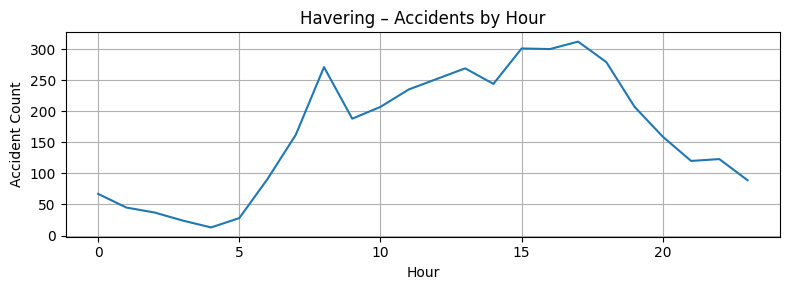

In [4]:
# Save as run_havering_analysis.py
import pandas as pd, numpy as np, os
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# 1. FILE PATHS FOR PYCHARM
csv_path = "AccidentLondonBoroughs2223.csv"      # <— local file
out_dir = "analysis_outputs"                      # <— folder in your project
os.makedirs(out_dir, exist_ok=True)

# 2. LOAD CSV
df = pd.read_csv(csv_path, low_memory=False)

print("Loaded rows:", len(df))

# 3. FILTER HAVERING
if "Local_Authority_Highway" in df.columns:
    hav = df[df["Local_Authority_Highway"] == "E09000016"].copy()
else:
    # fallback if column name is different
    hav = df[df.apply(lambda r: r.astype(str).str.contains("Havering", case=False).any(), axis=1)]

print("Havering rows:", len(hav))

# 4. PARSE TIME + DATE
if "Time" in hav.columns:
    hav["Time_parsed"] = pd.to_datetime(hav["Time"], errors="ignore")
    hav["Hour"] = pd.to_datetime(hav["Time"], errors="coerce").dt.hour

if "Date" in hav.columns:
    hav["Date_parsed"] = pd.to_datetime(hav["Date"], errors="coerce")
    hav["Weekday"] = hav["Date_parsed"].dt.day_name()
    hav["Month"] = hav["Date_parsed"].dt.month


# 5. SAVE BASIC SUMMARIES
hav.to_csv(os.path.join(out_dir, "havering_raw_subset.csv"), index=False)
pd.DataFrame({"total_rows":[len(df)], "havering_rows":[len(hav)]}).to_csv(os.path.join(out_dir,"counts.csv"), index=False)

# Missing values
missing = hav.isna().sum().reset_index()
missing.columns = ["column", "missing_count"]
missing["missing_pct"] = 100 * missing["missing_count"] / len(hav)
missing.to_csv(os.path.join(out_dir,"havering_missing.csv"), index=False)

# 6. K-MEANS CLUSTERING
numeric_feats = ["Number_of_Vehicles","Number_of_Casualties","Hour",
                 "Easting","Northing","Longitude","Latitude"]
numeric_feats = [c for c in numeric_feats if c in hav.columns]

cluster_df = hav[numeric_feats].dropna()

scaler = StandardScaler()
Xc = scaler.fit_transform(cluster_df)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=20)
cluster_df["cluster"] = kmeans.fit_predict(Xc)

# Save centers
cluster_centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=cluster_df.columns[:-1]
)
cluster_centers.to_csv(os.path.join(out_dir, "cluster_centers.csv"), index=False)

# Save sizes
cluster_df["cluster"].value_counts().to_csv(os.path.join(out_dir,"cluster_sizes.csv"))

# 7. DECISION TREE
severity_col = None
for c in hav.columns:
    if c.lower() in ("severity","accident_severity"):
        severity_col = c
        break

if severity_col:
    preds = [c for c in ["Number_of_Vehicles","Number_of_Casualties","Hour",
                         "Light_Conditions","Road_Surface_Conditions",
                         "Weather_Conditions","Urban_or_Rural_Area"] if c in hav.columns]

    model_df = hav[preds + [severity_col]].dropna()

    # Encode categoricals
    for col in preds:
        if model_df[col].dtype == object:
            model_df[col] = LabelEncoder().fit_transform(model_df[col].astype(str))

    X = model_df[preds].values
    y = model_df[severity_col].astype(int).values

    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=42)

    dt = DecisionTreeClassifier(max_depth=6, random_state=42)
    dt.fit(Xtr, ytr)
    ypred = dt.predict(Xte)

    # Save report
    with open(os.path.join(out_dir,"decision_tree_report.txt"), "w") as f:
        f.write(f"Accuracy: {accuracy_score(yte, ypred)}\n")
        f.write(str(confusion_matrix(yte, ypred)) + "\n\n")
        f.write(classification_report(yte, ypred))
        f.write("\n\nRules:\n")
        f.write(export_text(dt, feature_names=preds))

# 8. SAVE HOURLY PLOT
if "Hour" in hav.columns:
    hour_counts = hav["Hour"].dropna().astype(int).value_counts().sort_index()
    plt.figure(figsize=(8,3))
    plt.plot(hour_counts.index, hour_counts.values)
    plt.title("Havering – Accidents by Hour")
    plt.xlabel("Hour")
    plt.ylabel("Accident Count")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "accidents_by_hour_havering.png"))


Loaded dataset: 145222 rows
Havering subset: 4023 rows


C:\Users\MD Shahedul\AppData\Local\Temp\ipykernel_5992\2865163418.py:38: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  hav["Hour"] = pd.to_datetime(hav["Time"], errors="coerce").dt.hour


🎉 All visuals and summaries generated inside /visuals folder!


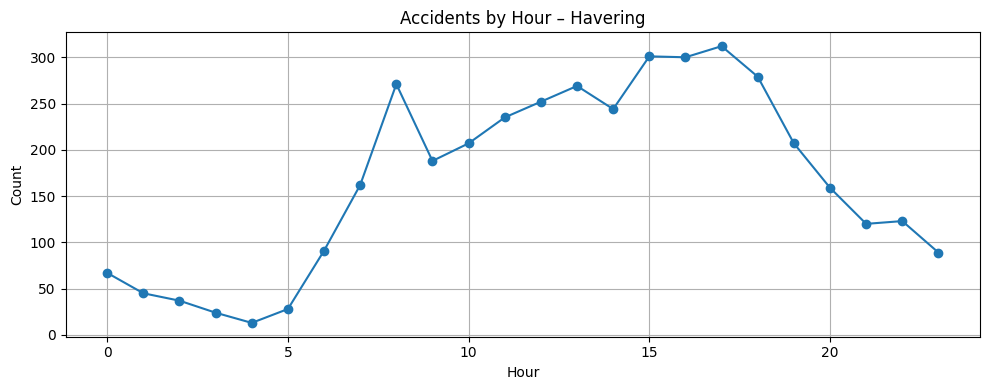

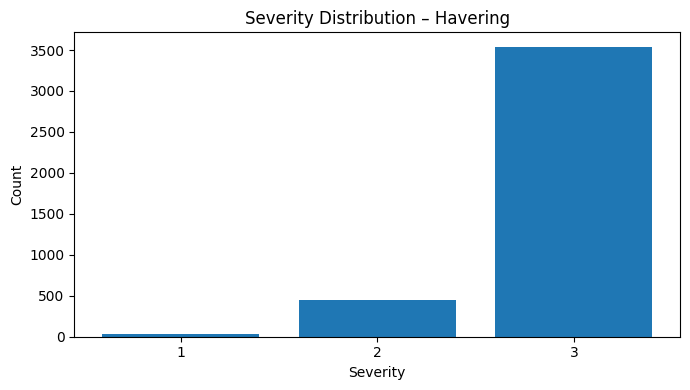

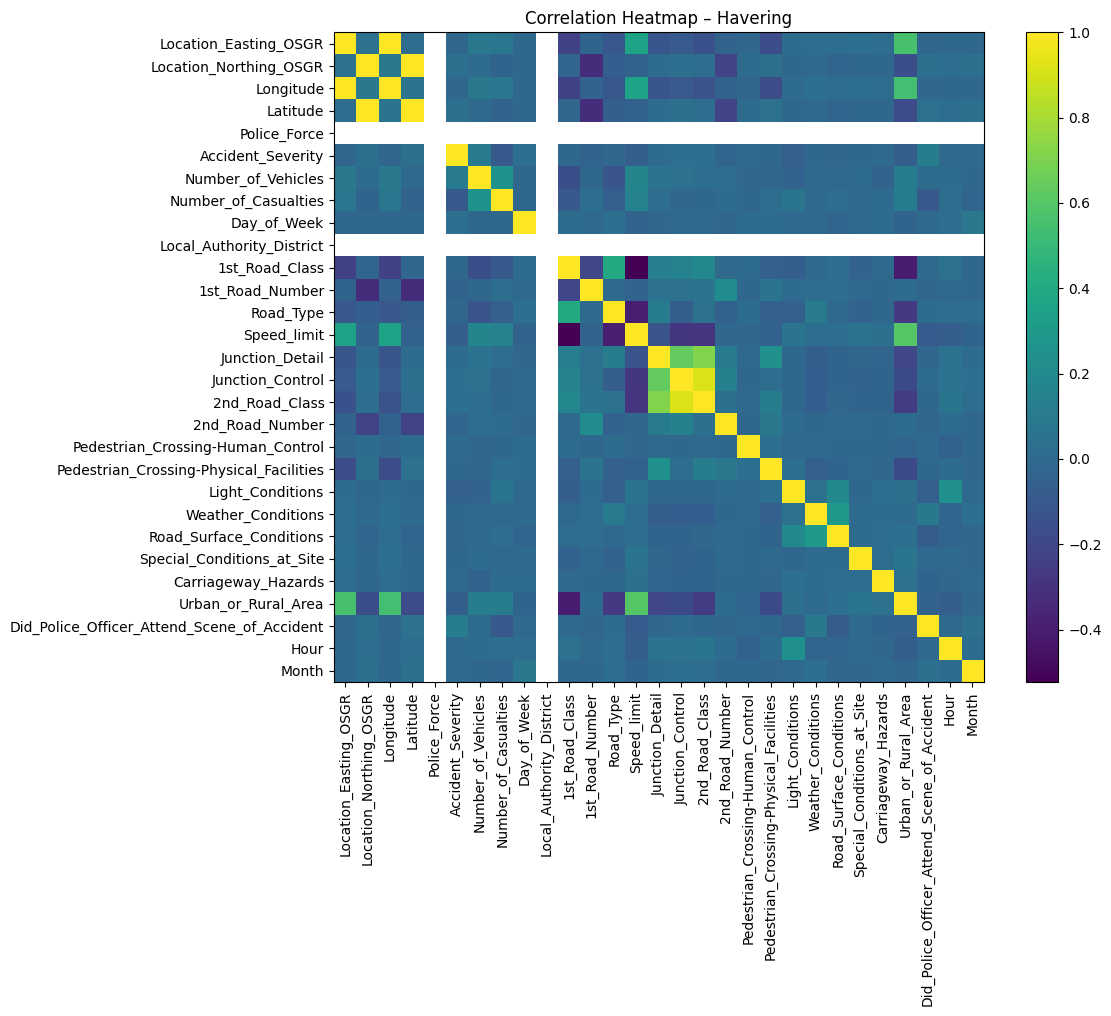

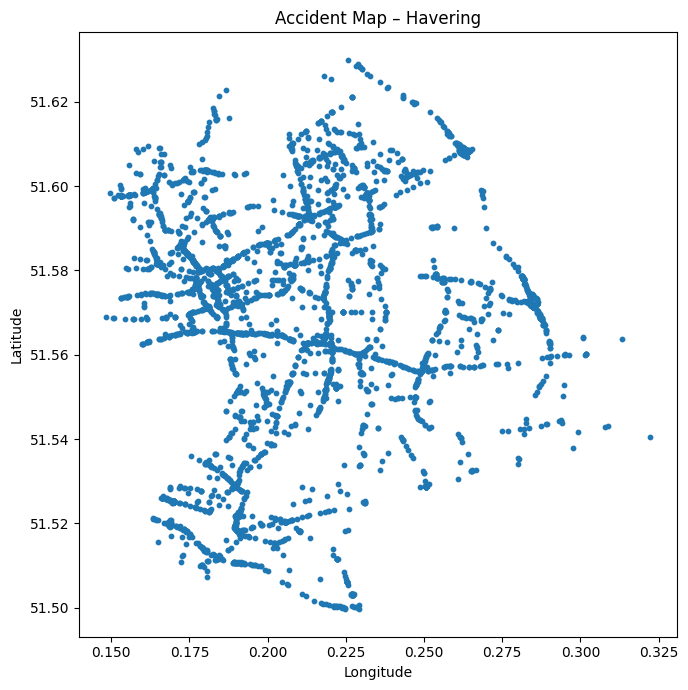

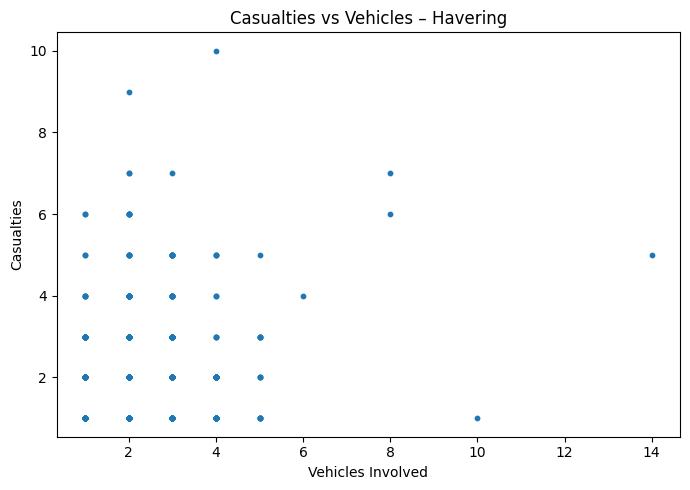

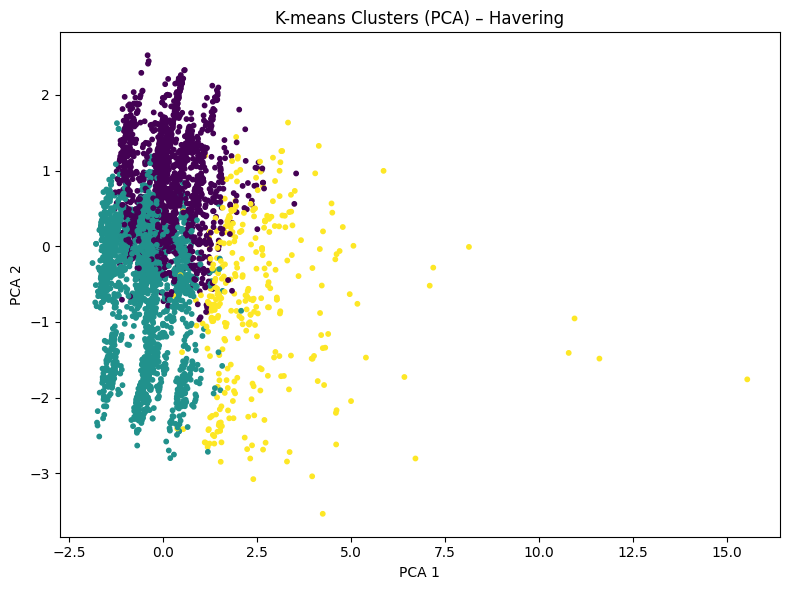

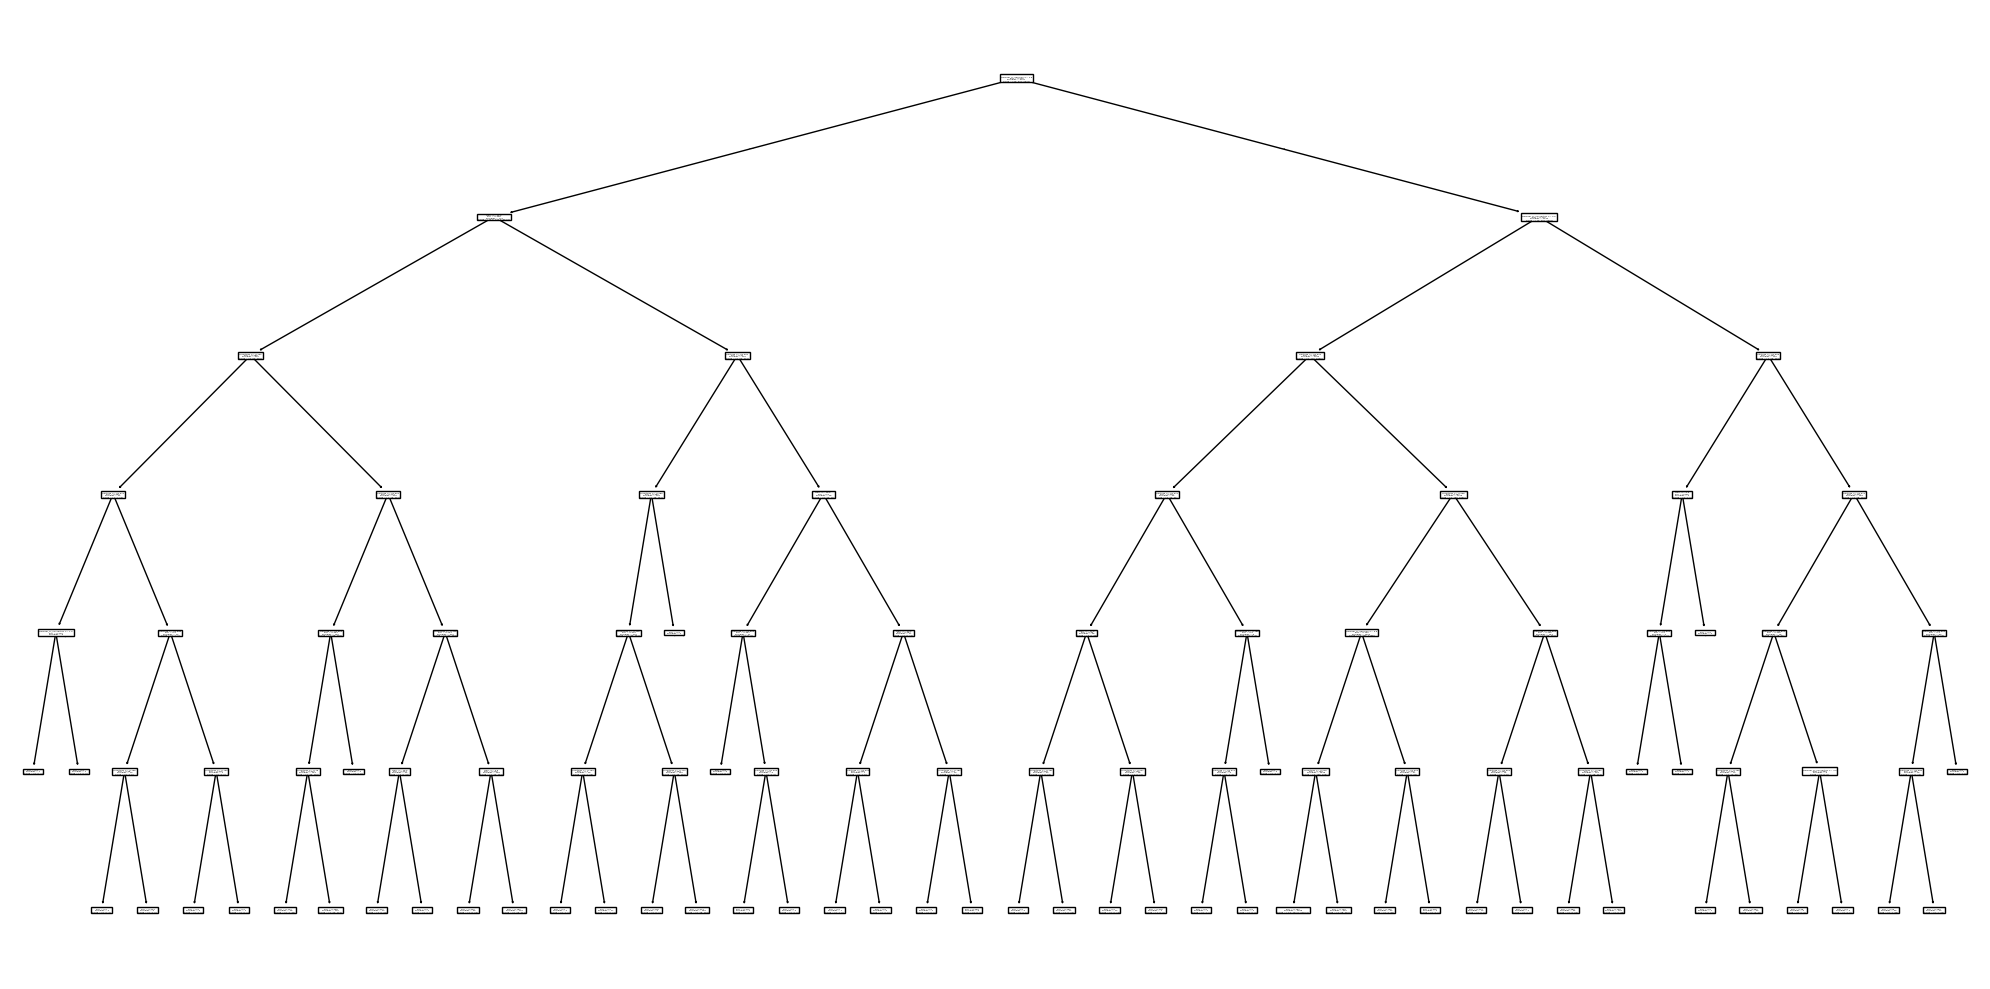

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Load dataset
df = pd.read_csv("AccidentLondonBoroughs2223.csv", low_memory=False)

# Filter Havering borough
if "Local_Authority_Highway" in df.columns:
    hav = df[df["Local_Authority_Highway"] == "E09000016"].copy()
else:
    hav = df[df.apply(lambda r: r.astype(str).str.contains("Havering", case=False).any(), axis=1)].copy()

print(f"Loaded dataset: {len(df)} rows")
print(f"Havering subset: {len(hav)} rows")


# Create output folder
out_dir = "visuals"
os.makedirs(out_dir, exist_ok=True)


# Feature Engineering
if "Time" in hav.columns:
    hav["Hour"] = pd.to_datetime(hav["Time"], errors="coerce").dt.hour

if "Date" in hav.columns:
    hav["Date_parsed"] = pd.to_datetime(hav["Date"], errors="coerce")
    hav["Weekday"] = hav["Date_parsed"].dt.day_name()
    hav["Month"] = hav["Date_parsed"].dt.month


# 1. Hourly Accident Distribution
if "Hour" in hav.columns:
    counts = hav["Hour"].value_counts().sort_index()

    plt.figure(figsize=(10,4))
    plt.plot(counts.index, counts.values, marker='o')
    plt.grid(True)
    plt.title("Accidents by Hour – Havering")
    plt.xlabel("Hour")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(f"{out_dir}/hourly_accidents.png")


# 2. Severity Distribution
severity = None
for col in hav.columns:
    if col.lower() in ("severity", "accident_severity"):
        severity = col

if severity:
    sev = hav[severity].value_counts().sort_index()

    plt.figure(figsize=(7,4))
    plt.bar(sev.index.astype(str), sev.values)
    plt.xlabel("Severity")
    plt.ylabel("Count")
    plt.title("Severity Distribution – Havering")
    plt.tight_layout()
    plt.savefig(f"{out_dir}/severity_distribution.png")


# 3. Correlation Heatmap
numeric = hav.select_dtypes(include=[np.number]).columns
corr = hav[numeric].corr()

plt.figure(figsize=(12,10))
plt.imshow(corr, interpolation='nearest', cmap='viridis')
plt.colorbar()
plt.xticks(range(len(numeric)), numeric, rotation=90)
plt.yticks(range(len(numeric)), numeric)
plt.title("Correlation Heatmap – Havering")
plt.tight_layout()
plt.savefig(f"{out_dir}/correlation_heatmap.png")


# 4. Longitude vs Latitude Scatter (GIS-like)
if "Longitude" in hav.columns and "Latitude" in hav.columns:
    plt.figure(figsize=(7,7))
    plt.scatter(hav["Longitude"], hav["Latitude"], s=10)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Accident Map – Havering")
    plt.tight_layout()
    plt.savefig(f"{out_dir}/longitude_latitude_scatter.png")


# 5. Casualties vs Vehicles Scatter

if "Number_of_Vehicles" in hav.columns and "Number_of_Casualties" in hav.columns:
    plt.figure(figsize=(7,5))
    plt.scatter(hav["Number_of_Vehicles"], hav["Number_of_Casualties"], s=10)
    plt.xlabel("Vehicles Involved")
    plt.ylabel("Casualties")
    plt.title("Casualties vs Vehicles – Havering")
    plt.tight_layout()
    plt.savefig(f"{out_dir}/casualties_vs_vehicles.png")


# 6. K-Means Clusters with PCA
features = [c for c in ["Number_of_Vehicles","Number_of_Casualties",
                        "Hour","Longitude","Latitude","Easting","Northing"]
            if c in hav.columns]

data = hav[features].dropna()

if len(data) > 20:
    scaler = StandardScaler()
    Xn = scaler.fit_transform(data)

    kmeans = KMeans(n_clusters=3, random_state=42, n_init=20)
    labels = kmeans.fit_predict(Xn)

    pca = PCA(n_components=2)
    xp = pca.fit_transform(Xn)

    plt.figure(figsize=(8,6))
    plt.scatter(xp[:,0], xp[:,1], c=labels, s=10)
    plt.title("K-means Clusters (PCA) – Havering")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.tight_layout()
    plt.savefig(f"{out_dir}/kmeans_pca_clusters.png")

    # Save centres
    centers = scaler.inverse_transform(kmeans.cluster_centers_)
    pd.DataFrame(centers, columns=features).to_csv(f"{out_dir}/cluster_centres.csv", index=False)


# 7. Decision Tree – Severity Prediction
if severity and len(data) > 20:

    predictors = features
    model = hav[predictors + [severity]].dropna()

    # Encode categoricals
    for c in predictors:
        if model[c].dtype == object:
            le = LabelEncoder()
            model[c] = le.fit_transform(model[c].astype(str))

    # Target encoding
    if model[severity].dtype == object:
        se = LabelEncoder()
        model[severity] = se.fit_transform(model[severity].astype(str))

    X = model[predictors].values
    y = model[severity].values

    Xtr, Xte, ytr, yte = train_test_split(X,y,test_size=0.25,random_state=42)

    dt = DecisionTreeClassifier(max_depth=6)
    dt.fit(Xtr, ytr)

    plt.figure(figsize=(20,10))
    plot_tree(dt, feature_names=predictors, filled=False)
    plt.tight_layout()
    plt.savefig(f"{out_dir}/decision_tree.png")

    # Save report
    with open(f"{out_dir}/decision_tree_report.txt","w") as f:
        f.write(f"Accuracy: {accuracy_score(yte, dt.predict(Xte))}\n\n")
        f.write(str(confusion_matrix(yte, dt.predict(Xte))) + "\n\n")
        f.write(classification_report(yte, dt.predict(Xte)) + "\n\n")
        f.write(export_text(dt, feature_names=predictors))


print("🎉 All visuals and summaries generated inside /visuals folder!")


In [6]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# Load Havering subset (from your earlier code)
df = pd.read_csv("AccidentLondonBoroughs2223.csv", low_memory=False)
hav = df[df["Local_Authority_Highway"]=="E09000016"].copy()

# Select relevant categorical attributes
cols = ["Light_Conditions", "Road_Surface_Conditions", "Weather_Conditions"]
sev = None
for c in hav.columns:
    if c.lower() in ("severity","accident_severity","accidentseverity"):
        sev = c

cols.append(sev)

# Drop rows with missing
model_df = hav[cols].dropna()

# One-hot encode
df_hot = pd.get_dummies(model_df)

# Run Apriori
frequent = apriori(df_hot, min_support=0.02, use_colnames=True)

# Generate rules
rules = association_rules(frequent, metric="confidence", min_threshold=0.5)

# Sort rules by confidence
rules = rules.sort_values("confidence", ascending=False)

# Save results
rules.to_csv("visuals/association_rules.csv", index=False)

print(rules.head(10))


C:\Users\MD Shahedul\PycharmProjects\pythonProject1\.venv\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


ValueError: The allowed values for a DataFrame are True, False, 0, 1. Found value 2

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Features for regression
features = ["Number_of_Vehicles", "Hour"]
target = "Number_of_Casualties"

reg_df = hav[features + [target]].dropna()

X = reg_df[features].values
y = reg_df[target].values

# Train/test split
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit model
lr = LinearRegression()
lr.fit(Xtr, ytr)

# Predictions
ypred = lr.predict(Xte)

# Save metrics
import math
rmse = math.sqrt(mean_squared_error(yte, ypred))
r2 = r2_score(yte, ypred)

print("RMSE:", rmse)
print("R2:", r2)
print("Coefficients:", lr.coef_)
print("Intercept:", lr.intercept_)

# Scatter plot
plt.figure(figsize=(7,5))
plt.scatter(yte, ypred, s=10)
plt.xlabel("Actual Casualties")
plt.ylabel("Predicted Casualties")
plt.title("Regression: Actual vs Predicted Casualties")
plt.tight_layout()
plt.savefig("visuals/regression_scatter.png")
plt.close()


KeyError: "['Hour'] not in index"

In [9]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# Load
df = pd.read_csv("AccidentLondonBoroughs2223.csv", low_memory=False)
hav = df[df["Local_Authority_Highway"]=="E09000016"].copy()

# Choose attributes
cols = ["Light_Conditions", "Road_Surface_Conditions", "Weather_Conditions"]
sev = None
for c in hav.columns:
    if c.lower() in ("severity","accident_severity","accidentseverity"):
        sev = c

cols.append(sev)

# Drop missing
model_df = hav[cols].dropna()

# One-hot encode
df_hot = pd.get_dummies(model_df)

# 🔥 IMPORTANT conversion here
df_hot = df_hot.applymap(lambda x: 1 if x > 0 else 0)

# Apriori
frequent = apriori(df_hot, min_support=0.02, use_colnames=True)

# Rules
rules = association_rules(frequent, metric="confidence", min_threshold=0.5)

# Sort
rules = rules.sort_values("confidence", ascending=False)

# Save
rules.to_csv("visuals/association/association_rules.csv", index=False)

print(rules.head(10))


C:\Users\MD Shahedul\AppData\Local\Temp\ipykernel_5992\2844230740.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_hot = df_hot.applymap(lambda x: 1 if x > 0 else 0)
C:\Users\MD Shahedul\PycharmProjects\pythonProject1\.venv\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
C:\Users\MD Shahedul\PycharmProjects\pythonProject1\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


OSError: Cannot save file into a non-existent directory: 'visuals\association'

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import math

# Ensure Hour exists
if "Hour" not in hav.columns and "Time" in hav.columns:
    hav["Hour"] = pd.to_datetime(hav["Time"], errors="coerce").dt.hour

# Features for regression
features = ["Number_of_Vehicles", "Hour"]
target = "Number_of_Casualties"

# Drop missing
reg_df = hav[features + [target]].dropna()

X = reg_df[features].values
y = reg_df[target].values

# Train/test split
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit model
lr = LinearRegression()
lr.fit(Xtr, ytr)

# Predictions
ypred = lr.predict(Xte)

# Metrics
rmse = math.sqrt(mean_squared_error(yte, ypred))
r2 = r2_score(yte, ypred)

print("RMSE:", rmse)
print("R2:", r2)
print("Coefficients:", lr.coef_)
print("Intercept:", lr.intercept_)

# Scatter plot
plt.figure(figsize=(7,5))
plt.scatter(yte, ypred, s=10)
plt.xlabel("Actual Casualties")
plt.ylabel("Predicted Casualties")
plt.title("Regression: Actual vs Predicted Casualties")
plt.tight_layout()
plt.savefig("visuals/regression_scatter.png")
plt.close()


NameError: name 'hav' is not defined

In [3]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 9))
plot_tree(
    dt,
    feature_names=preds,
    class_names=y_le.classes_,
    filled=True,
    rounded=True,
    fontsize=6
)
plt.tight_layout()
plt.savefig("visuals/decision_tree.png")
plt.close()


NameError: name 'dt' is not defined

<Figure size 1800x900 with 0 Axes>

In [4]:
# 7. Decision Tree – Severity Prediction
if severity and len(data) > 20:

    predictors = features
    model = hav[predictors + [severity]].dropna()

    # Encode categoricals
    for c in predictors:
        if model[c].dtype == object:
            le = LabelEncoder()
            model[c] = le.fit_transform(model[c].astype(str))

    # Target encoding
    if model[severity].dtype == object:
        se = LabelEncoder()
        model[severity] = se.fit_transform(model[severity].astype(str))

    X = model[predictors].values
    y = model[severity].values

    # 🔥 train/test split
    Xtr, Xte, ytr, yte = train_test_split(
        X, y,
        test_size=0.25,
        random_state=42,
        stratify=y
    )

    # 🔥 train model
    dt = DecisionTreeClassifier(max_depth=6)
    dt.fit(Xtr, ytr)

    # 🔥 nicer decision tree plot
    plt.figure(figsize=(22, 12))
    plot_tree(
        dt,
        feature_names=predictors,
        class_names=[str(c) for c in np.unique(y)],
        filled=True,
        rounded=True,
        fontsize=7
    )
    plt.tight_layout()
    plt.savefig(f"{out_dir}/decision_tree.png", dpi=300)
    plt.close()

    # Save report
    with open(f"{out_dir}/decision_tree_report.txt","w") as f:
        f.write(f"Accuracy: {accuracy_score(yte, dt.predict(Xte))}\n\n")
        f.write(str(confusion_matrix(yte, dt.predict(Xte))) + "\n\n")
        f.write(classification_report(yte, dt.predict(Xte)) + "\n\n")
        f.write(export_text(dt, feature_names=predictors))


NameError: name 'severity' is not defined

In [5]:
# 7. Decision Tree – Severity Prediction

# Ensure column is identified:
severity = None
for col in hav.columns:
    if col.lower() in ("severity", "accident_severity"):
        severity = col

if severity:
    predictors = features  # re-use features list from clustering
    model = hav[predictors + [severity]].dropna()

    # Encode categorical predictors
    for c in predictors:
        if model[c].dtype == object:
            model[c] = LabelEncoder().fit_transform(model[c].astype(str))

    # Encode target
    model[severity] = LabelEncoder().fit_transform(model[severity].astype(str))

    X = model[predictors].values
    y = model[severity].values

    # Train/test split
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

    # Train tree
    dt = DecisionTreeClassifier(max_depth=6, random_state=42)
    dt.fit(Xtr, ytr)

    # Plot nicely
    plt.figure(figsize=(22, 12))
    plot_tree(
        dt,
        feature_names=predictors,
        class_names=[str(c) for c in np.unique(y)],
        filled=True,
        rounded=True,
        fontsize=7
    )
    plt.tight_layout()
    plt.savefig(f"{out_dir}/decision_tree.png", dpi=300)
    plt.close()

    # Save evaluation report
    with open(f"{out_dir}/decision_tree_report.txt","w") as f:
        f.write(f"Accuracy: {accuracy_score(yte, dt.predict(Xte))}\n\n")
        f.write(str(confusion_matrix(yte, dt.predict(Xte))) + "\n\n")
        f.write(classification_report(yte, dt.predict(Xte)) + "\n\n")
        f.write(export_text(dt, feature_names=predictors))


NameError: name 'hav' is not defined

In [6]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# --- Create a nicer visual tree ---
plt.figure(figsize=(24, 14))  # BIG = readable

plot_tree(
    dt,
    feature_names=preds,
    class_names=y_le.classes_ if "y_le" in locals() else None,
    filled=True,               # coloured boxes by class
    rounded=True,              # rounded corners
    fontsize=10,               # readable text
    proportion=True            # makes it compact
)

plt.title("Decision Tree – Accident Severity Prediction", fontsize=16)
plt.tight_layout()
plt.savefig(f"{out_dir}/decision_tree_nice.png", dpi=300)  # high resolution
plt.close()


NameError: name 'dt' is not defined

<Figure size 2400x1400 with 0 Axes>

In [7]:

# Train Decision Tree
severity_col = None
for c in hav.columns:
    if c.lower() in ("severity","accident_severity"):
        severity_col = c
        break

if severity_col:
    preds = [c for c in [
        "Number_of_Vehicles","Number_of_Casualties","Hour",
        "Light_Conditions","Road_Surface_Conditions",
        "Weather_Conditions","Urban_or_Rural_Area"
    ] if c in hav.columns]

    # Build model dataframe
    model_df = hav[preds + [severity_col]].dropna()

    # Encode categorical predictors
    for col in preds:
        if model_df[col].dtype == object:
            le = LabelEncoder()
            model_df[col] = le.fit_transform(model_df[col].astype(str))

    # Encode target
    y_le = LabelEncoder()
    model_df[severity_col] = y_le.fit_transform(model_df[severity_col].astype(str))

    X = model_df[preds].values
    y = model_df[severity_col].values

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )

    # Train model
    from sklearn.tree import DecisionTreeClassifier
    dt = DecisionTreeClassifier(max_depth=6, random_state=42)
    dt.fit(X_train, y_train)


NameError: name 'hav' is not defined

In [8]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Load dataset

csv_path = "AccidentLondonBoroughs2223.csv"
df = pd.read_csv(csv_path, low_memory=False)

# 2. Filter Havering borough
if "Local_Authority_Highway" in df.columns:
    hav = df[df["Local_Authority_Highway"] == "E09000016"].copy()
else:
    hav = df[df.apply(lambda r: r.astype(str).str.contains("Havering", case=False).any(), axis=1)].copy()

print("Havering rows:", len(hav))

# 3. Feature engineering
if "Time" in hav.columns:
    hav["Hour"] = pd.to_datetime(hav["Time"], errors="coerce").dt.hour

if "Date" in hav.columns:
    hav["Date_parsed"] = pd.to_datetime(hav["Date"], errors="coerce")
    hav["Weekday"] = hav["Date_parsed"].dt.day_name()
    hav["Month"] = hav["Date_parsed"].dt.month

# 4. Find severity column
severity_col = None
for c in hav.columns:
    if c.lower() in ("severity","accident_severity"):
        severity_col = c
        break

print("Severity column:", severity_col)

# 5. Build decision tree ONLY if severity exists
if severity_col is not None:

    # predictors available
    preds = [c for c in [
        "Number_of_Vehicles","Number_of_Casualties","Hour",
        "Light_Conditions","Road_Surface_Conditions",
        "Weather_Conditions","Urban_or_Rural_Area"
    ] if c in hav.columns]

    # model dataframe
    model_df = hav[preds + [severity_col]].dropna()

    # encode predictors
    for col in preds:
        if model_df[col].dtype == object:
            model_df[col] = LabelEncoder().fit_transform(model_df[col].astype(str))

    # encode target
    y_le = LabelEncoder()
    model_df[severity_col] = y_le.fit_transform(model_df[severity_col].astype(str))

    X = model_df[preds].values
    y = model_df[severity_col].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )

    # Train decision tree
    dt = DecisionTreeClassifier(max_depth=6, random_state=42)
    dt.fit(X_train, y_train)

    # Visualise decision tree (beautiful)
    out_dir = "analysis_outputs"
    os.makedirs(out_dir, exist_ok=True)

    plt.figure(figsize=(24, 14))
    plot_tree(
        dt,
        feature_names=preds,
        class_names=y_le.classes_,
        filled=True,
        rounded=True,
        fontsize=10,
        proportion=True
    )
    plt.title("Decision Tree – Accident Severity Prediction", fontsize=18)
    plt.tight_layout()
    plt.savefig(f"{out_dir}/decision_tree_nice.png", dpi=300)
    plt.close()

    # Save report
    with open(f"{out_dir}/decision_tree_report.txt","w") as f:
        f.write(f"Accuracy: {accuracy_score(y_test, dt.predict(X_test))}\n\n")
        f.write("Confusion matrix:\n")
        f.write(str(confusion_matrix(y_test, dt.predict(X_test))) + "\n\n")
        f.write("Classification report:\n")
        f.write(classification_report(y_test, dt.predict(X_test), zero_division=0))



Havering rows: 4023
Severity column: Accident_Severity


C:\Users\MD Shahedul\AppData\Local\Temp\ipykernel_4212\2628936015.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  hav["Hour"] = pd.to_datetime(hav["Time"], errors="coerce").dt.hour


🌳 Done! Tree saved at: analysis_outputs/decision_tree_nice.png
